In [1]:
import pickle
import numpy as np

In [2]:
pickle_filename = "data/glove_embedding_salinfo_ENG.pkl"
salary_yvals = pickle.load( open( pickle_filename, "rb"))

In [3]:
numpy_filename = "data/glove_embeddings_of_dataset_ENG.mat.npy"

embedding_matrix = np.load(numpy_filename)

In [4]:
embedding_matrix.shape

(10930, 49, 300)

In [5]:
len(salary_yvals)

10930

In [6]:
print(salary_yvals[0])

(60000, 100000, 18)


In [7]:
num_examples, max_words, embed_size = embedding_matrix.shape


In [8]:
recognized_word = 0
unrecognized_word = 0

for ex in range(num_examples):
    ex_words = salary_yvals[ex][2]
    slice_embed = embedding_matrix[ex,0:ex_words,:]
    for w in range(ex_words):
        single_slice = slice_embed[w,:]
        if np.array_equal( single_slice, np.zeros((embed_size,))):
            unrecognized_word += 1
        else:
            recognized_word += 1
        
print("Num recognized words: " + str(recognized_word))
print("Num unrecognized words: " + str(unrecognized_word))

print("Percentage: " + str(recognized_word / (unrecognized_word + recognized_word)))

Num recognized words: 203827
Num unrecognized words: 10478
Percentage: 0.9511070670306339


In [9]:
print(num_examples)

10930


In [10]:
##Create Model Where You Make Embedding As Max:
max_embeddings = np.zeros((num_examples,300))
avg_embeddings = np.zeros((num_examples,300))


for ex in range(num_examples):
    ex_words = salary_yvals[ex][2]
    slice_embed = embedding_matrix[ex,0:ex_words,:]
    
    maxvals = np.amax( slice_embed, axis=0 )
    max_embeddings[ex,:] = maxvals
    
    avgvals = np.mean( slice_embed, axis=0 )
    avg_embeddings[ex,:] = avgvals
    

In [11]:
##Now feed this to linear model and to SVM

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score


In [12]:
salary_options = ["avg_salary", "min_salary", "max_salary"]
salary_model_data = {}
dataset_dictionary = {}

for option in salary_options:
    dataset_dictionary[option] = []

##convert min and max salaries to floats
for ex in range(num_examples):
    dataset_dictionary["min_salary"].append(float( salary_yvals[ex][0] ) )
    dataset_dictionary["max_salary"].append( float( salary_yvals[ex][1] ) )
    dataset_dictionary["avg_salary"].append( float( (salary_yvals[ex][1] + salary_yvals[ex][0]) / 2.0 ) )
    

seed_val = 1991

for el in salary_options:
    X_train, X_test, y_train, y_test = train_test_split( avg_embeddings, dataset_dictionary[el] , random_state=seed_val, test_size=500)
    salary_model_data[el] = {}
    salary_model_data[el]["X_train"] = X_train
    salary_model_data[el]["X_test"] = X_test
    salary_model_data[el]["y_train"] = y_train
    salary_model_data[el]["y_test"] = y_test

    salary_model_data[el]["regressor"] = LinearRegression(fit_intercept=True)


In [13]:
for el in salary_options:
    salary_model_data[el]["regressor"].fit(  X=salary_model_data[el]["X_train"], \
            y=salary_model_data[el]["y_train"] )

##Calculate how good the model is
for el in salary_options:
    #mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
    y_pred = salary_model_data[el]["regressor"].predict( salary_model_data[el]["X_test"] )
    y_true = salary_model_data[el]["y_test"]

    y_pred_train = salary_model_data[el]["regressor"].predict( salary_model_data[el]["X_train"] )
    y_true_train = salary_model_data[el]["y_train"]

    salary_model_data[el]["y_pred"] = y_pred
    salary_model_data[el]["y_pred_train"] = y_pred_train
                  
    datasets = [ ("test", y_pred, y_true), ("train", y_pred_train, y_true_train) ]

    for d in datasets:
        salary_model_data[el]["MSE_"+d[0]] = mean_squared_error(d[2], d[1])
        salary_model_data[el]["MAE_"+d[0]] = mean_absolute_error(d[2], d[1])
        salary_model_data[el]["MEDAE_"+d[0]] = median_absolute_error(d[2], d[1])
        salary_model_data[el]["r2_"+d[0]] = r2_score(d[2], d[1])

metric_names = ["MSE", "MAE", "MEDAE", "r2"]
dataset_names = ["_test", "_train"]
for el in salary_options:
    print("Summary data for " + str(el) + " model ")
    for m in metric_names:
        print(m + ":")
        for d in dataset_names:
            print(d + ": " + str(salary_model_data[el][m+d]))


Summary data for avg_salary model 
MSE:
_test: 671661172.0800645
_train: 703338402.3407981
MAE:
_test: 19553.560116773373
_train: 18878.10328563431
MEDAE:
_test: 15694.483148543666
_train: 14878.788318301173
r2:
_test: 0.2458820849515363
_train: 0.33280001295675055
Summary data for min_salary model 
MSE:
_test: 575162274.7726332
_train: 626199278.4485066
MAE:
_test: 18036.84437788246
_train: 17719.171894801864
MEDAE:
_test: 13319.402291638435
_train: 13685.198164162983
r2:
_test: 0.22221922121804893
_train: 0.293683911797896
Summary data for max_salary model 
MSE:
_test: 969702941.3655971
_train: 956485533.3081706
MAE:
_test: 23747.339147450424
_train: 22548.47199683884
MEDAE:
_test: 19253.998587257534
_train: 17805.370935888903
r2:
_test: 0.22792753317036263
_train: 0.32975650432761805


In [14]:
import matplotlib.pyplot as plt


i=1
fig=plt.figure(figsize=(18, 16))

for el in salary_options:

    y_train_predictions = salary_model_data[el]["y_pred_train"]
    y_train_true = salary_model_data[el]["y_train"]
    
    #true_v_pred = list(zip(y_train_true, y_train_predictions))
    #true_v_pred.sort() 
    #true_sorted = [x[0] for x in true_v_pred]
    #pred_sorted = [x[1] for x in true_v_pred]
    
    true_sorted_indices = np.argsort(y_train_true)
    true_sorted = [y_train_true[true_sorted_indices[i]] for i in range(len(true_sorted_indices))]
    pred_sorted = [y_train_predictions[true_sorted_indices[i]] for i in range(len(true_sorted_indices))]
    
    true_sorted = [x for x in true_sorted if x < 200000]
    pred_sorted = pred_sorted[0:len(true_sorted)]
    
    xvals = range(len(true_sorted))
    plt.subplot(2,2,i)
    plt.scatter(x=xvals, y=pred_sorted)
    plt.scatter(x=xvals, y=true_sorted)
    
    plt.legend(["predicted", "actual"])
    i+=1

plt.show()

<Figure size 1800x1600 with 3 Axes>

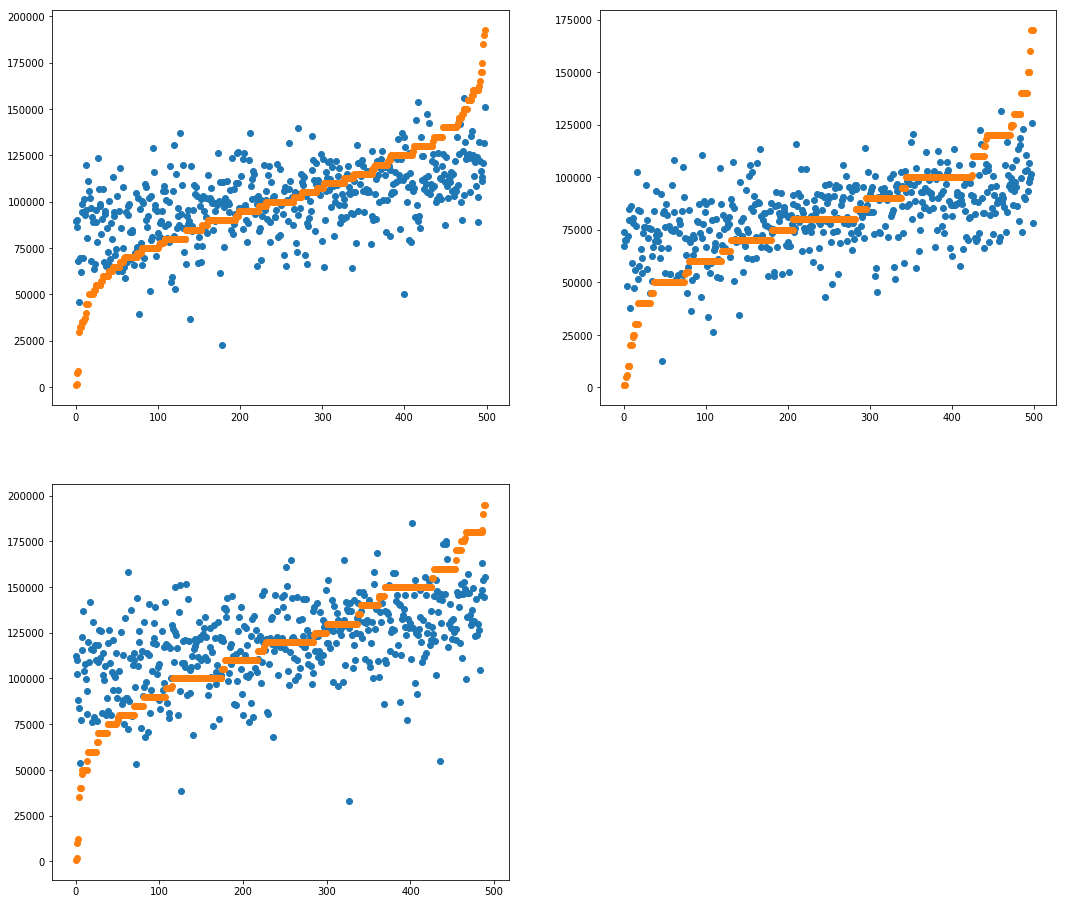

In [15]:
import matplotlib.pyplot as plt


i=1
fig=plt.figure(figsize=(18, 16))

for el in salary_options:
    y_test_predictions = salary_model_data[el]["y_pred"]
    y_train_predictions = salary_model_data[el]["y_pred_train"]
    
    y_test_true= salary_model_data[el]["y_test"]
    y_train_true = salary_model_data[el]["y_train"]
    
    #true_v_pred = list(zip(y_test_true, y_test_predictions))
    #true_v_pred.sort()
        
    #true_sorted = [x[0] for x in true_v_pred]
    #pred_sorted = [x[1] for x in true_v_pred]
    
    true_sorted_indices = np.argsort(y_test_true)
    true_sorted = [y_test_true[true_sorted_indices[i]] for i in range(len(true_sorted_indices))]
    pred_sorted = [y_test_predictions[true_sorted_indices[i]] for i in range(len(true_sorted_indices))]
    
    true_sorted = [x for x in true_sorted if x < 200000]
    pred_sorted = pred_sorted[0:len(true_sorted)]
    
    
    xvals = range(len(true_sorted))
    plt.subplot(2,2,i)
    
    plt.scatter(x=xvals, y=pred_sorted)
    plt.scatter(x=xvals, y=true_sorted)
    i+=1

plt.show()





In [16]:
min_sal_buckets = range(50000,210000,10000)
num_buckets = len(min_sal_buckets)+1

def min_class_bucket(salary):
    proper_bucket = -1

    if salary < min_sal_buckets[0]:
        return 0

    elif salary >= min_sal_buckets[-1]:
        return len(min_sal_buckets)

    for i in range(1,len(min_sal_buckets)):

        if salary >= min_sal_buckets[i-1] and salary < min_sal_buckets[i]:
            return i

In [17]:
for el in salary_options:
    y_test_true= salary_model_data[el]["y_test"]
    y_train_true = salary_model_data[el]["y_train"]
    
    y_test_bucket_true = []
    y_train_bucket_true = []
    
    for t in y_test_true:
        y_test_bucket_true.append(min_class_bucket(t))
    
    for t in y_train_true:
        y_train_bucket_true.append(min_class_bucket(t))

    salary_model_data[el]["y_test_bucket"] = y_test_bucket_true
    salary_model_data[el]["y_train_bucket"] = y_train_bucket_true
        

In [18]:
from sklearn.svm import LinearSVC, SVC

for el in salary_options:
    salary_model_data[el]["svm_model"] = SVC(gamma = 'scale')
    
    X_t = salary_model_data[el]["X_train"]
    y_t = salary_model_data[el]["y_train_bucket"]
    salary_model_data[el]["svm_model"].fit(X_t, y_t)
    
    
    

In [19]:
from sklearn.metrics import accuracy_score

for el in salary_options:
    X_train = salary_model_data[el]["X_train"]
    X_test = salary_model_data[el]["X_test"]
    y_train_pred = salary_model_data[el]["svm_model"].predict(X_train)
    y_test_pred = salary_model_data[el]["svm_model"].predict(X_test)
    
    salary_model_data[el]["svm_train_pred"] = y_train_pred
    salary_model_data[el]["svm_test_pred"] = y_test_pred
    
    y_train_true = salary_model_data[el]["y_train_bucket"]
    y_test_true = salary_model_data[el]["y_test_bucket"]
    
    
    
    print(el + " train accuracy: " + str(accuracy_score(y_train_pred, y_train_true)) )
    print(el + " test accuracy: " + str(accuracy_score(y_test_pred, y_test_true)) )

avg_salary train accuracy: 0.17296260786193673
avg_salary test accuracy: 0.146
min_salary train accuracy: 0.22627037392138064
min_salary test accuracy: 0.226
max_salary train accuracy: 0.1769894534995206
max_salary test accuracy: 0.144


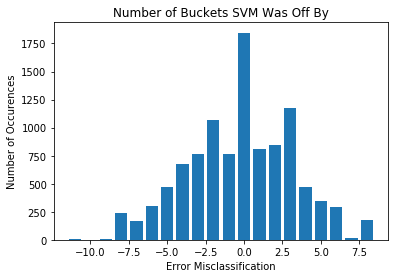

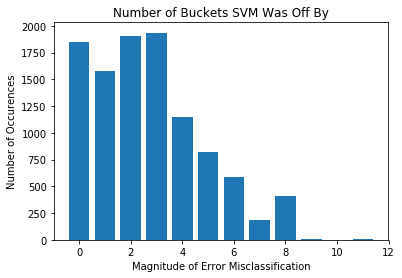

In [20]:
import numpy as np
import matplotlib.pyplot as plt 
#Lets look at how far we are off
Y_train =  salary_model_data["min_salary"]["y_train_bucket"] 
Y_train_pred =  salary_model_data["min_salary"]["svm_train_pred"] 

dif_matrix = Y_train - Y_train_pred
unique, counts = np.unique(dif_matrix, return_counts=True)
my_class_counts = dict(zip(unique, counts))

dif_matrix_abs = np.abs(dif_matrix)
unique, counts = np.unique(dif_matrix_abs, return_counts=True)
my_class_counts_abs = dict(zip(unique, counts))

x_count = [int(v) for v in my_class_counts.keys()]
y_count = [my_class_counts[v] for v in my_class_counts.keys()]

x_count_abs = [int(v) for v in my_class_counts_abs.keys()]
y_count_abs = [my_class_counts_abs[v] for v in my_class_counts_abs.keys()]

plt.clf()
plt.bar(x_count,y_count)
plt.xlabel('Error Misclassification')
plt.ylabel('Number of Occurences')
plt.title('Number of Buckets SVM Was Off By')
plt.show()

plt.clf()
plt.bar(x_count_abs,y_count_abs)
plt.xlabel('Magnitude of Error Misclassification')
plt.ylabel('Number of Occurences')
plt.title('Number of Buckets SVM Was Off By')
plt.show()


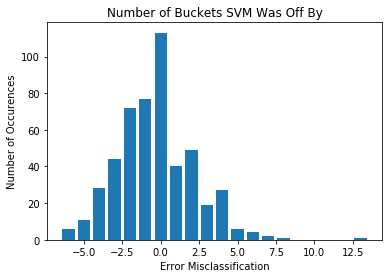

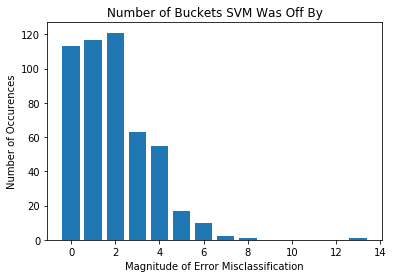

In [21]:
import numpy as np
#Lets look at how far we are off
Y_train =  salary_model_data["min_salary"]["y_test_bucket"] 
Y_train_pred =  salary_model_data["min_salary"]["svm_test_pred"] 

dif_matrix = Y_train - Y_train_pred
unique, counts = np.unique(dif_matrix, return_counts=True)
my_class_counts = dict(zip(unique, counts))

dif_matrix_abs = np.abs(dif_matrix)
unique, counts = np.unique(dif_matrix_abs, return_counts=True)
my_class_counts_abs = dict(zip(unique, counts))

x_count = [int(v) for v in my_class_counts.keys()]
y_count = [my_class_counts[v] for v in my_class_counts.keys()]

x_count_abs = [int(v) for v in my_class_counts_abs.keys()]
y_count_abs = [my_class_counts_abs[v] for v in my_class_counts_abs.keys()]

plt.clf()
plt.bar(x_count,y_count)
plt.xlabel('Error Misclassification')
plt.ylabel('Number of Occurences')
plt.title('Number of Buckets SVM Was Off By')
plt.show()

plt.clf()
plt.bar(x_count_abs,y_count_abs)
plt.xlabel('Magnitude of Error Misclassification')
plt.ylabel('Number of Occurences')
plt.title('Number of Buckets SVM Was Off By')
plt.show()


In [22]:

total_rec = sum(counts)
zero_to_one_bucket = sum(counts[0:2])
print("Percentage off by 1 bucket or less on test set: " + str( zero_to_one_bucket / total_rec) )


Percentage off by 1 bucket or less on test set: 0.46
